In [1]:
## looking into public services accessibility by zip-code, alderman district
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib
from matplotlib.pyplot import plot

calls_service = pd.read_csv('./data/mfdems.csv') # EMS Calls for Service Milwaukee
liq_lic = pd.read_csv('./data/liquorlicenses.csv') # Liquor License data Milwaukee
## https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-zip-code-data-soi
nat_irs_16 = pd.read_csv('./data/16zpallagi.csv') # IRS Data 2016
nat_irs_16['zipcode'] = nat_irs_16['zipcode'].astype(np.float64)

In [2]:
print(calls_service.info())
print(nat_irs_16.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118921 entries, 0 to 118920
Data columns (total 5 columns):
Original Call for Service Type    118921 non-null object
Final Call for Service Type       118921 non-null object
Incident Date                     118921 non-null object
ZIP Code                          100792 non-null float64
Aldermanic District               112679 non-null float64
dtypes: float64(2), object(3)
memory usage: 4.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179796 entries, 0 to 179795
Columns: 147 entries, STATEFIPS to A11902
dtypes: float64(1), int64(145), object(1)
memory usage: 201.6+ MB
None


In [3]:
mke_zipcodes = [x for x in calls_service['ZIP Code'].unique() if ~np.isnan(x)]
mke_alderdists = [x for x in calls_service['Aldermanic District'].unique() if ~np.isnan(x)]
mke_irs_16 = nat_irs_16[nat_irs_16['zipcode'].isin(mke_zipcodes)]
mke_irs_16.head()

,STATEFIPS,STATE,zipcode,agi_stub,N1,mars1,MARS2,MARS4,PREP,N2,...,N10300,A10300,N85530,A85530,N85300,A85300,N11901,A11901,N11902,A11902
174830,55,WI,53051.0,1,5240,4460,530,230,1980,4570,...,2360,1824,0,0,0,0,480,302,4070,4469
174831,55,WI,53051.0,2,3810,2530,850,370,1680,5600,...,3490,9943,0,0,0,0,660,789,3050,5726
174832,55,WI,53051.0,3,2820,1340,1210,230,1420,5220,...,2740,16056,0,0,0,0,650,1174,2070,4988
174833,55,WI,53051.0,4,2290,480,1660,130,1130,5440,...,2270,19562,0,0,0,0,590,1398,1640,4875
174834,55,WI,53051.0,5,3880,350,3430,100,1900,11110,...,3860,66942,20,8,0,0,1340,4769,2390,9419


In [4]:
mke_zip_irs = mke_irs_16[['zipcode','N1','N2','NUMDEP','ELDERLY']].groupby(['zipcode']).sum()
mke_zip_irs.columns = ['returns','exemptions','dependents','elderly']
mke_zip_irs.head()

,returns,exemptions,dependents,elderly
zipcode,,,,
53051.0,19360,36240,9780,5950
53110.0,9290,16160,4400,2440
53130.0,4150,7360,1900,1290
53132.0,17430,33400,9420,5470
53154.0,18000,33730,9850,3940


In [5]:
mke_zip_agi_irs = mke_irs_16[['zipcode','agi_stub','N1','N2','NUMDEP','ELDERLY']].groupby(['zipcode','agi_stub']).sum()
mke_zip_agi_irs.columns = ['returns','exemptions','dependents','elderly']
mke_zip_agi_irs['returns_pct_zip'] = 100 * mke_zip_agi_irs['returns'] / mke_zip_agi_irs.groupby(level=[0])['returns'].transform('sum')
mke_zip_agi_irs.head()

returns  exemptions  dependents  elderly  returns_pct_zip
zipcode agi_stub                                                           
53051.0 1            5240        4570         540     1660        27.066116
        2            3810        5600         970     1220        19.679752
        3            2820        5220        1190     1000        14.566116
        4            2290        5440        1500      780        11.828512
        5            3880       11110        3810     1020        20.041322

In [30]:
import shapefile
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

# zipcode shape data from http://gis-mclio.opendata.arcgis.com/
zip_shp = shapefile.Reader("./shape/mke_zipcode/Zip_Code_Tabulation_Areas_ZCTA")

def plot_df_on_mke_zip_map(df, agi_idx):
    fig = plt.figure(figsize=(12,10))
    ax = plt.axes()
    ax.set_aspect('equal')
    plt.title('agi_stub = '+str(agi_idx))

    available_data = np.array(df.index.tolist()).astype(int).astype(str)

    for i, shape in enumerate(zip_shp.shapes()):
        if zip_shp.record(i)[1] in available_data:
            R = 0
            G = 0
            B = df[agi_idx][float(zip_shp.record(i)[1])] / max(df[agi_idx])
            # annotate the shape with aldermanic district number
            center_x = shape.bbox[0]+((shape.bbox[2]-shape.bbox[0])/2)
            center_y = shape.bbox[1]+((shape.bbox[3]-shape.bbox[1])/2)
            ax.annotate(zip_shp.record(i)[1],xy=(center_x,center_y),color='tan',
                        ha='center',va='center',fontsize=11)
        else: # if area has no occurrences
            R = 1
            G = 1
            B = 1
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=[R,G,B], alpha=0.7, edgecolor=[1,1,1], zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0=shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)
                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=[R,G,B], edgecolor=[1,0,0], alpha=0.7, zorder=2)
                ax.add_patch(patch)

    plt.xlim(zip_shp.bbox[0],zip_shp.bbox[2])
    plt.ylim(zip_shp.bbox[1],zip_shp.bbox[3])
    plt.axis('off')
    fig.savefig('./images/AGI_'+str(agi_idx)+'_2016_zipcode.png')

agi_stub     1     2     3     4     5     6
zipcode                                     
53051.0   5240  3810  2820  2290  3880  1320
53110.0   3310  2680  1550   920   770    60
53130.0   1220   940   670   470   730   120
53132.0   4750  3140  2440  2120  3880  1100
53154.0   5240  4150  2940  2080  3170   420


ValueError: could not convert string to float: 

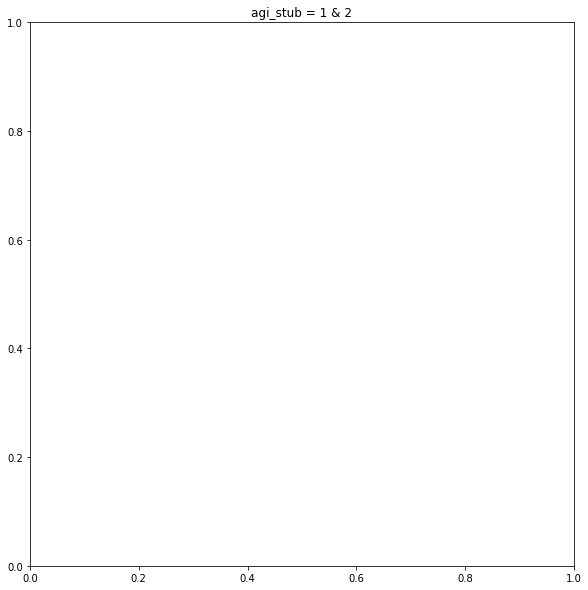

In [32]:
agi_foreach_zip = mke_irs_16[['zipcode','agi_stub','N1']].pivot(index='zipcode',columns='agi_stub',values='N1')
print(agi_foreach_zip.head())
plot_df_on_mke_zip_map(agi_foreach_zip,1)

In [8]:
agi_by_zip = mke_irs_16[['zipcode','agi_stub','N1']].pivot(index='zipcode',columns='agi_stub',values='N1')
pop_by_zip = mke_irs_16[['zipcode','N1']].groupby(['zipcode']).agg(['sum'])['N1']
errythang = pop_by_zip.join(agi_by_zip)
errythang.head()

,sum,1,2,3,4,5,6
zipcode,,,,,,,
53051.0,19360,5240,3810,2820,2290,3880,1320
53110.0,9290,3310,2680,1550,920,770,60
53130.0,4150,1220,940,670,470,730,120
53132.0,17430,4750,3140,2440,2120,3880,1100
53154.0,18000,5240,4150,2940,2080,3170,420


In [9]:
df=calls_service
df['Incident Date'] = pd.to_datetime(df['Incident Date'])
df['Incident Date'] = df['Incident Date'].dt.strftime('%Y-%m')
call_types = [x for x in df['Final Call for Service Type'].unique()]
call_types.sort()
print(call_types)

['ALARM', 'APPL', 'AUTOF', 'AUTOX', 'Abdominal Pain/Problems', 'Academy - Medical', 'Allergies (Reactions)/Envenomations (Stings, Bites)', 'Animal Bites/Attacks', 'Assault/Sexual Assault', 'Auto Accident', 'Auto Accident - Multiple Injuries', 'BTB1', 'BTB2', 'BTB3', 'Back Pain (Non-Traumatic or Non-Recent Trauma)', 'Bariatric Patient', 'Breathing Problems', 'Burns (Scalds)/Explosion (Blast)', 'CARBON', 'CTB1', 'CTB2', 'CTB3', 'Carbon Monoxide/Inhalation/Hazmat/CBRN', 'Cardiac or Respiratory Arrest/Death', 'Chest Pain (Non-Traumatic)', 'Choking', 'Combative Patient', 'Community Paramedic', 'Convulsions/Seizures', 'DIVE', 'Diabetic Problems', 'Downgraded Response', 'Drowning (Near)/Diving/Scuba Accident', 'ELECT', 'ELEV', 'ER', 'Electrocution/Lightning', 'Eye Problems/Injuries', 'FBRESP', 'FLUSH', 'FORCE', 'FULL', 'FULL2', 'FULL3', 'FULL4', 'Falls', 'Fire Station', 'GARAGE', 'GAS', 'GMIA2', 'GMIA3', 'GRASS', 'HAZMAT', 'HEAT', 'HIRISE1', 'HIRISE3', 'HRRESP', 'HURT', 'HURTRESP', 'Headache'

In [10]:
## group by original call type and aggregate by count
df.groupby('Original Call for Service Type').agg(['count'])['Incident Date'].sort_values(by='count',ascending=False).head()

,count
Original Call for Service Type,
Sick Person (Specific Diagnosis),18346
Breathing Problems,12116
Unknown Problem (Man Down),8604
Falls,7400
Traffic/Transportation Accidents,7211


In [11]:
## group by final call type and aggregate by count
df.groupby('Final Call for Service Type').agg(['count'])['Incident Date'].sort_values(by='count',ascending=False).head()

,count
Final Call for Service Type,
Sick Person (Specific Diagnosis),17342
Breathing Problems,10815
Unknown Problem (Man Down),7824
Falls,6943
Traffic/Transportation Accidents,6525


In [12]:
## Clearly there is a difference between the listings of original call type and final call type
df.groupby(['Original Call for Service Type','Final Call for Service Type']).agg(['count'])

Incident Date  \
                                                                                     count   
Original Call for Service Type Final Call for Service Type                                   
ALARM                          ALARM                                                  4801   
                               APPL                                                      1   
                               CARBON                                                    1   
                               ELEV                                                      1   
                               FULL                                                      9   
                               HIRISE1                                                   4   
                               LHAZMAT                                                   1   
                               LR                                                        1   
                               OOCFIRE                                                   1   
                               SMOKE                                                    13   
                               WATER                                                     1   
APPL                           APPL                                                    299   
                               AUTOF                                                     2   
                               FULL                                                     12   
                               LR                                                        1   
                               SMOKE                                                     1   
AUTOF                          AUTOF                                                   743   
                               AUTOX                                                     6   
                               FULL                                                      1   
                               GARAGE                                                   13   
                               HAZMAT                                                    2   
                               MFDPI                                                     1   
AUTOX                          AUTOX                                                   332   
                               CTB1                                                      2   
                               MTB2                                                      2   
                               PTB1                                                      2   
                               PTB3                                                      1   
                               Traffic/Transportation Accidents                          3   
Abdominal Pain/Problems        Abdominal Pain/Problems                                2630   
                               Assault/Sexual Assault                                    1   
...                                                                                    ...   
Unknown Problem (Man Down)     FORCE                                                    11   
                               Falls                                                     7   
                               Fire Station                                              1   
                               GAS                                                       1   
                               Headache                                                  6   
                               Heart Problems/A.I.C.D.                                   2   
                               Heat/Cold Exposure                                        3   
                               Hemorrhage/Lacerations                                    1   
                               MED Special Call                                          7   
                               MED 

In [13]:
all_calls_by_zip = df[["ZIP Code","Original Call for Service Type"]].groupby(['ZIP Code'], as_index=True).agg(['count']).sort_values(by='ZIP Code', ascending=True)['Original Call for Service Type']
all_calls_by_zip.columns = ['ServiceCalls']
sick_byZip = df[df['Original Call for Service Type']=='Sick Person (Specific Diagnosis)'].groupby('ZIP Code',as_index=True).agg(['count'])['Original Call for Service Type']
sick_byZip.columns=['SickPerson']

service_byZip = all_calls_by_zip.join(sick_byZip)
#
errythang.sort_values(by='zipcode')
service_byZip.sort_values(by= 'ZIP Code')
errythang = errythang.merge(service_byZip, left_index=True, right_index=True, how='left')
errythang.sort_values(by=['ServiceCalls','SickPerson'], ascending=False)

,sum,1,2,3,4,5,6,ServiceCalls,SickPerson
zipcode,,,,,,,,,
53206.0,8380,5790,2000,390,120,80,0,8945,1595.0
53209.0,19900,9860,5340,2180,1120,1170,230,8527,1511.0
53218.0,16670,8980,5100,1610,610,370,0,7854,1368.0
53204.0,15660,8920,4930,1130,330,240,110,6834,1152.0
53212.0,12930,6560,3770,1360,570,520,150,6725,1218.0
53216.0,13580,6950,4050,1440,640,460,40,6632,1136.0
53215.0,24440,12170,8210,2580,910,540,30,6065,940.0
53208.0,12570,6340,3420,1390,630,680,110,5997,1064.0
53210.0,10650,5900,2850,950,420,490,40,5966,1075.0


In [14]:
# MKE Service Call data
cardiac = df[df['Final Call for Service Type']=='Cardiac or Respiratory Arrest/Death'].groupby(['Aldermanic District'], as_index=True).agg(['count'])['Final Call for Service Type']
cardiac.columns = ['CardiacOrRespiratoryArrestOrDeath']
downgraded = df[df['Final Call for Service Type']=='Downgraded Response'].groupby(['Aldermanic District'], as_index=False).agg(['count'])['Final Call for Service Type']
downgraded.columns = ['DowngradedResponse']
#### Assault is only organized by Aldermanic District; can't get it by ZIP Code
assault_byAldDist = df[df['Final Call for Service Type']=='Assault/Sexual Assault'].groupby('Aldermanic District',as_index=True).agg(['count'])['Final Call for Service Type']
assault_byAldDist.columns=['AssaultSexualAssault']
any_service_call = df[['Aldermanic District','Final Call for Service Type']].groupby(['Aldermanic District'], as_index=True).agg(['count'])['Final Call for Service Type']
any_service_call.columns = ['ServiceCalls']
## MKE Liquor License data
liq_avail = liq_lic[['ALDERMANIC_DISTRICT','EXP_DATE']].groupby(['ALDERMANIC_DISTRICT'], as_index=True).agg(['count']).sort_values(by='ALDERMANIC_DISTRICT', ascending=True)['EXP_DATE']
liq_avail.columns=['LiquorLicenses']

In [15]:
any_card_down = any_service_call.join(cardiac.join(downgraded)).join(assault_byAldDist)
all_byAldDist = any_card_down.merge(liq_avail,left_index=True,right_index=True,how='left')

In [16]:
all_byAldDist.sort_values(by=['ServiceCalls','AssaultSexualAssault','CardiacOrRespiratoryArrestOrDeath','DowngradedResponse','LiquorLicenses'], ascending=False)

,ServiceCalls,CardiacOrRespiratoryArrestOrDeath,DowngradedResponse,AssaultSexualAssault,LiquorLicenses
Aldermanic District,,,,,
15.0,12867,96,362,878,58
6.0,11953,82,206,756,99
4.0,11200,86,301,408,269
1.0,10595,68,194,591,35
7.0,10492,81,263,646,30
2.0,8807,77,248,466,22
9.0,8024,106,106,294,32
12.0,7033,81,206,425,188
8.0,5276,68,92,274,68


In [17]:
## Notice that District 4 is in the top five of all three lists!
## That's not a good thing

In [18]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

ald_shp = shapefile.Reader("./shape/ald2018/alderman")

In [19]:
# plots a comparison of MKE aldermanic districts based on the input parameter, call_type
def plot_df_on_mke_ald_map(df,col):
    fig = plt.figure(figsize=(12,10))
    plt.title(col)
    ax = plt.axes()
    ax.set_aspect('equal')

    for i, shape in enumerate(ald_shp.shapes()):
        # define polygon fill color (facecolor) RGB values:
        R = df[col][float(ald_shp.record(i)[1])] / max(df[col])
        G = 0.1
        B = 0.1
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=[R,G,B], alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0=shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)
                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=[R,G,B], alpha=1.0, zorder=2)
                ax.add_patch(patch)
        # annotate the shape with aldermanic district number
        center_x = shape.bbox[0]+((shape.bbox[2]-shape.bbox[0])/2)
        center_y = shape.bbox[1]+((shape.bbox[3]-shape.bbox[1])/2)
        ax.annotate(ald_shp.record(i)[1],xy=(center_x,center_y),color='tan',
                    ha='center',va='center',fontsize=21)
    plt.xlim(ald_shp.bbox[0],ald_shp.bbox[2])
    plt.ylim(ald_shp.bbox[1],ald_shp.bbox[3])
    plt.axis('off')
    fig.savefig('./images/EMS_' + col + '_2018_alddist.png')

C:\Users\Peter\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


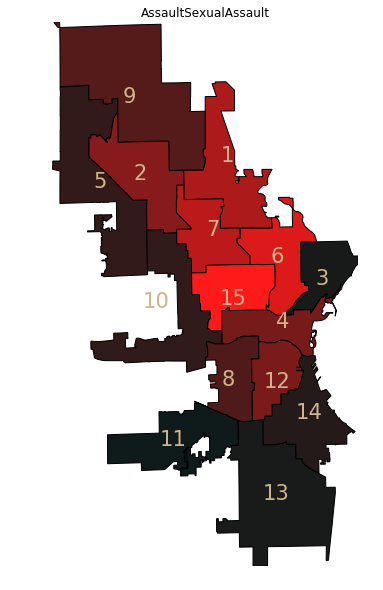

In [20]:
plot_df_on_mke_ald_map(all_byAldDist,'AssaultSexualAssault')

C:\Users\Peter\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


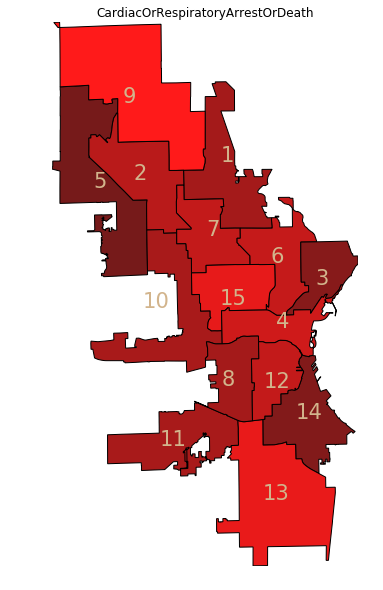

In [21]:
plot_df_on_mke_ald_map(all_byAldDist,'CardiacOrRespiratoryArrestOrDeath')

C:\Users\Peter\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


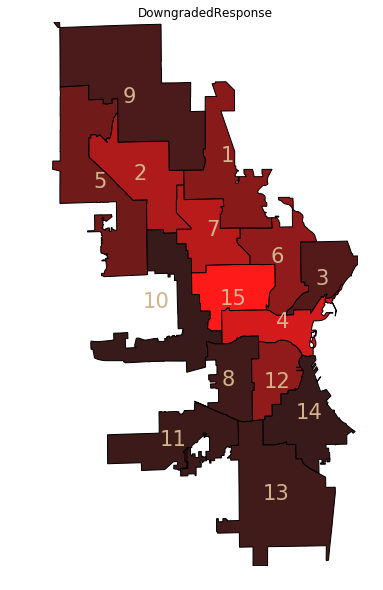

In [22]:
plot_df_on_mke_ald_map(all_byAldDist,'DowngradedResponse')

C:\Users\Peter\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


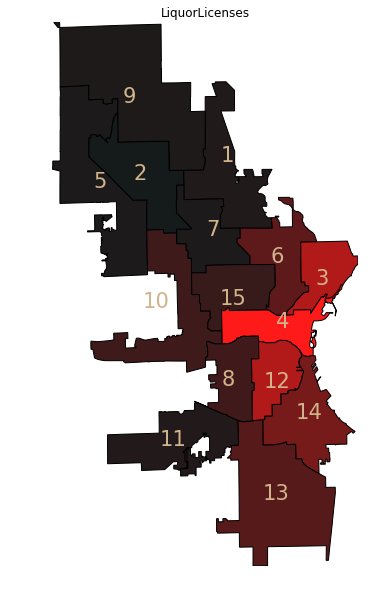

In [23]:
plot_df_on_mke_ald_map(all_byAldDist,'LiquorLicenses')